Źródła:

Gu, Jindong, et al. "A survey on transferability of adversarial examples across deep neural networks." arXiv preprint arXiv:2310.17626 (2023).

Podder, Rakesh, and Sudipto Ghosh. "Impact of white-box adversarial attacks on convolutional neural networks." 2024 International Conference on Emerging Trends in Networks and Computer Communications (ETNCC). IEEE, 2024.

Qin, Yunxiao, et al. "Training meta-surrogate model for transferable adversarial attack." Proceedings of the AAAI conference on artificial intelligence. Vol. 37. No. 8. 2023.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Preparing VGG model
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Blok 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

model_vgg = VGG16(num_classes=10)
model_vgg.load_state_dict(torch.load("vgg_epoch_80.pth", map_location=torch.device("cpu")))
# model_vgg.load_state_dict(torch.load("vgg_epoch_10.pth", map_location=device))
# model_vgg.to(device) 
model_vgg.eval()


VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [4]:
# Preparing ResNet18 model
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3,
                      stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(output_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or input_channels != output_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.main_path(x) + self.shortcut(x)
        out = self.relu(out)
        return out
    

class ResNet18(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=64, stride=1),
            BasicBlock(input_channels=64, output_channels=64, stride=1)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(input_channels=64, output_channels=128, stride=2),
            BasicBlock(input_channels=128, output_channels=128, stride=1)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(input_channels=128, output_channels=256, stride=2),
            BasicBlock(input_channels=256, output_channels=256, stride=1)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(input_channels=256, output_channels=512, stride=2),
            BasicBlock(input_channels=512, output_channels=512, stride=1)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.classifier(out)
        return out
    

model_resnet = ResNet18(3, 10)
model_resnet.load_state_dict(torch.load("ResNet18_1_without_weight_decay/model_ResNet18_cifar10.pth", map_location=torch.device("cpu")))
# model_resnet.load_state_dict(torch.load("ResNet18_1_without_weight_decay/model_ResNet18_cifar10.pth", map_location=device))
# model_resnet.to(device) 
model_resnet.eval()

ResNet18(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (main_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
# Dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

In [ ]:
# Fast Gradient Sign Method (FGSM) 

def fgsm(model, image, label, epsilon=0.1):
    image.requires_grad_(True)
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, torch.tensor([label]))

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * torch.sign(image.grad)
    adversarial_image = image + perturbation
    return adversarial_image

In [ ]:
# Projected Gradient Descent (PGD)

def pgd(model, image, label, epsilon=0.03, alpha=0.05, num_iters=40):
    original_image = image.clone()
    adversarial_image = image.clone()
    
    for _ in range(num_iters):
        adversarial_image.requires_grad_(True)
        output = model(adversarial_image)
        loss = nn.CrossEntropyLoss()(output, torch.tensor([label]))
        
        model.zero_grad()
        loss.backward()
        
        with torch.no_grad():
            gradient = adversarial_image.grad.data
            adversarial_image += alpha * gradient.sign()
            
            perturbation = torch.clamp(adversarial_image - original_image, min=-epsilon, max=epsilon)
            adversarial_image = torch.clamp(original_image + perturbation, 0, 1)

        adversarial_image = adversarial_image.detach()
                
    return adversarial_image

In [6]:
# Adversarial attacks PyTorch: https://github.com/Harry24k/adversarial-attacks-pytorch/tree/master
# Attacks are generated using the VGG model and then transfered to the ResNet
from torchattacks import PGD, FGSM, CW

# Default parameters values
atk_fgsm = FGSM(model_vgg, eps=8/255)
atk_pgd = PGD(model_vgg, eps=8/255, alpha=2/225, steps=10, random_start=True)
atk_cw = CW(model_vgg, c=0.1, steps=1000, lr=0.01)
print(atk_fgsm)
print(atk_pgd)
print(atk_cw)

FGSM(model_name=VGG16, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.03137254901960784)
PGD(model_name=VGG16, device=cpu, attack_mode=default, targeted=False, normalization_used=False, eps=0.03137254901960784, alpha=0.008888888888888889, steps=10, random_start=True)
CW(model_name=VGG16, device=cpu, attack_mode=default, targeted=False, normalization_used=False, c=0.1, kappa=0, steps=1000, lr=0.01)


In [51]:
# Samples generation using only correctly classified examples by vgg model

def predict(model, images):
    with torch.no_grad():
        _, pred = model(images).max(1)
    return pred

n_examples = 100
data_samples = [testset[i] for i in range(n_examples)]
images = torch.stack([x[0] for x in data_samples])
labels = torch.tensor([x[1] for x in data_samples])
# images, labels = images.to(device), labels.to(device)

vgg_pred = predict(model_vgg, images)
correct_mask = vgg_pred.eq(labels)
images = images[correct_mask]
labels = labels[correct_mask]

print(f"Original batch size: {n_examples}")
print(f"Number of correctly classified examples: {images.size(0)}")

adv_images_fgsm = atk_fgsm(images, labels)
adv_images_pgd = atk_pgd(images, labels)
adv_images_cw = atk_cw(images, labels)


Original batch size: 100
Number of correctly classified examples: 90


KeyboardInterrupt: 

In [ ]:
vgg_pred_fgsm = predict(model_vgg, adv_images_fgsm)
vgg_pred_pgd = predict(model_vgg, adv_images_pgd)
vgg_pred_cw = predict(model_vgg, adv_images_cw)

resnet_pred = predict(model_resnet, images)
resnet_pred_fgsm = predict(model_resnet, adv_images_fgsm)
resnet_pred_pgd = predict(model_resnet, adv_images_pgd)
resnet_pred_cw = predict(model_resnet, adv_images_cw)

# print(labels)
# print("---------")
# print(vgg_pred_fgsm)
# print(vgg_pred_pgd)
# print(vgg_pred_cw)
# print("-----------")
# print(resnet_pred)
# print(resnet_pred_fgsm)
# print(resnet_pred_pgd)
# print(resnet_pred_cw)


tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])
---------
tensor([3, 0, 0, 0, 6, 6, 3, 6, 4, 9])
tensor([5, 0, 0, 0, 4, 5, 3, 8, 4, 9])
tensor([5, 0, 0, 0, 2, 3, 3, 8, 3, 9])
-----------
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])
tensor([3, 8, 0, 0, 6, 6, 5, 4, 3, 1])
tensor([3, 8, 0, 0, 6, 6, 5, 4, 3, 0])
tensor([3, 8, 0, 0, 6, 6, 5, 4, 3, 1])


In [ ]:
# Attack efficiency metrics

def accuracy(labels, preds):
    total = len(labels)
    correct = preds.eq(labels).sum().item()
    test_acc = 100.*correct/total

    return test_acc

def fooling_rate(labels, source_pred, target_pred, clean_target_pred):
    fool_source = source_pred != labels
    fool_target = target_pred != labels
    correct_target_pred = clean_target_pred == labels

    P = fool_source.sum().item()
    Q = (fool_source & fool_target & correct_target_pred).sum().item() # We count samples, which were correctly classified by target that fooled both models

    fool_rate = Q / P if P > 0 else 0.0
    return fool_rate

def same_mistake_rate(labels, source_pred, target_pred, clean_target_pred):
    correct_target_pred = (clean_target_pred == labels)
    fool_target = (target_pred != labels)
    same_mistake = (source_pred == target_pred)

    rate = (fool_target & same_mistake & correct_target_pred).sum().item() / (fool_target & correct_target_pred).sum().item() # We count the samples that fooled the model the same way taking into consideratoin only correctly classified samples by target
    return rate

# Perturbation quality metrics
import sewar

def ssim(images, adv_images):  # Structural Similarity Index Metric (SSIM) measures perceptual similarity between two images, considering luminance, contrast, and structure. We want to maximize this value
    ssim_list = []

    for i in range(images.size(0)):
        img_1 = images[i].permute(1, 2, 0).detach().cpu().numpy()
        img_2 = adv_images[i].permute(1, 2, 0).detach().cpu().numpy()

        img_1 = (img_1 * 255).clip(0, 255).astype(np.uint8)
        img_2 = (img_2 * 255).clip(0, 255).astype(np.uint8)

        ssim_val, _ = sewar.ssim(img_1, img_2)
        ssim_list.append(ssim_val)
    
    return float(np.mean(ssim_list))


In [50]:
# Metric values
import pandas as pd

correct_mask_resnet = resnet_pred.eq(labels)
attack_metrics = {
    "Attack": ["FGSM", "PGD", "CW"],
    "VGG Accuracy": [
        accuracy(labels, vgg_pred_fgsm),
        accuracy(labels, vgg_pred_pgd),
        accuracy(labels, vgg_pred_cw)
    ],
    "ResNet Accuracy (originally correct only)": [
        accuracy(labels[correct_mask_resnet], resnet_pred_fgsm[correct_mask_resnet]),
        accuracy(labels[correct_mask_resnet], resnet_pred_pgd[correct_mask_resnet]),
        accuracy(labels[correct_mask_resnet], resnet_pred_cw[correct_mask_resnet])
    ],
    "Fooling Rate (VGG -> ResNet)": [
        fooling_rate(labels, vgg_pred_fgsm, resnet_pred_fgsm, resnet_pred),
        fooling_rate(labels, vgg_pred_pgd, resnet_pred_pgd, resnet_pred),
        fooling_rate(labels, vgg_pred_cw, resnet_pred_cw, resnet_pred)
    ],
    "Same Mistake Rate (VGG -> ResNet)": [
        same_mistake_rate(labels, vgg_pred_fgsm, resnet_pred_fgsm, resnet_pred),
        same_mistake_rate(labels, vgg_pred_pgd, resnet_pred_pgd, resnet_pred),
        same_mistake_rate(labels, vgg_pred_cw, resnet_pred_cw, resnet_pred)
    ]
}

df_attack = pd.DataFrame(attack_metrics)
print("=== Attack Efficiency Metrics ===")
print(df_attack)

print("=== SSIM values ===")
print("SSIM for FGSM:", ssim(images, adv_images_fgsm))
print("SSIM for PDG:", ssim(images, adv_images_pgd))
print("SSIM for CW:", ssim(images, adv_images_cw))

=== Attack Efficiency Metrics ===
  Attack  VGG Accuracy  ResNet Accuracy (originally correct only)  \
0   FGSM          50.0                                       70.0   
1    PGD          10.0                                       60.0   
2     CW          20.0                                       70.0   

   Fooling Rate (VGG -> ResNet)  Same Mistake Rate (VGG -> ResNet)  
0                      0.400000                           0.333333  
1                      0.444444                           0.250000  
2                      0.375000                           0.333333  
=== SSIM values ===
SSIM for FGSM: 0.9963103156567119
SSIM for PDG: 0.9969092399852271
SSIM for CW: 0.9996308475728009


For n_examples = 10
=== Attack Efficiency Metrics ===
  Attack  VGG Accuracy  ResNet Accuracy (originally correct only)  \
0   FGSM          50.0                                       70.0   
1    PGD          10.0                                       60.0   
2     CW          20.0                                       70.0   

   Fooling Rate (VGG -> ResNet)  Same Mistake Rate (VGG -> ResNet)  
0                      0.400000                           0.333333  
1                      0.444444                           0.250000  
2                      0.375000                           0.333333  
=== SSIM values ===
SSIM for FGSM: 0.9963103156567119
SSIM for PDG: 0.9969092399852271
SSIM for CW: 0.9996308475728009

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8783362..1.5628136].


(-0.5, 31.5, 31.5, -0.5)

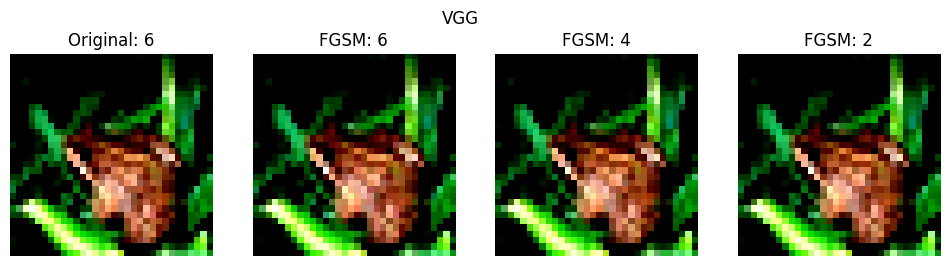

In [43]:
# Wisualization of one sample for VGG prediction
index = 4 # Index number must be lower than correctly classified examples

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fig.suptitle("VGG")
axs[0].imshow(images[index].permute(1, 2, 0).detach().numpy())
axs[0].set_title(f"Original: {labels[index]}")
axs[0].axis('off')

axs[1].imshow(adv_images_fgsm[index].permute(1, 2, 0).detach().numpy())
axs[1].set_title(f"FGSM: {vgg_pred_fgsm[index]}")
axs[1].axis('off')

axs[2].imshow(adv_images_pgd[index].permute(1, 2, 0).detach().numpy())
axs[2].set_title(f"FGSM: {vgg_pred_pgd[index]}")
axs[2].axis('off')

axs[3].imshow(adv_images_cw[index].permute(1, 2, 0).detach().numpy())
axs[3].set_title(f"FGSM: {vgg_pred_cw[index]}")
axs[3].axis('off')